In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from config import data_path
import statsmodels.api as sm

In [2]:
# Load options data, original format
df_option = pd.read_parquet(os.path.join(data_path, 'SPY_options.parquet'))
df_option = df_option[df_option['EXPIRE_DATE'] != '2015-12-19']
df_option = df_option[df_option['EXPIRE_DATE'] != '2018-12-23']
df_option.head()

,QUOTE_DATE,UNDERLYING_LAST,EXPIRE_DATE,DTE,STRIKE,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,C_BID,C_ASK,C_SIZE,...,P_ASK,P_SIZE,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME
0,2010-01-04,113.29,2010-01-15,11.0,55.0,58.3,0.515,58.20,58.40,305 x 270,...,0.02,0 x 1268,0.02,-0.00143,0.00010,0.00074,-0.00435,-0.00050,1.36742,0.0
1,2010-01-04,113.29,2010-01-15,11.0,56.0,57.3,0.506,57.20,57.40,305 x 270,...,0.01,0 x 1269,0.00,-0.00160,0.00020,0.00074,-0.00396,-0.00043,1.33476,NaN
2,2010-01-04,113.29,2010-01-15,11.0,57.0,56.3,0.497,56.20,56.39,305 x 270,...,0.01,0 x 1268,0.03,-0.00146,0.00014,0.00106,-0.00369,-0.00004,1.30655,0.0
3,2010-01-04,113.29,2010-01-15,11.0,58.0,55.3,0.488,55.19,55.40,304 x 269,...,0.03,0 x 1269,0.04,-0.00166,0.00017,0.00056,-0.00428,-0.00051,1.27237,0.0
4,2010-01-04,113.29,2010-01-15,11.0,59.0,54.3,0.479,54.20,54.40,304 x 269,...,0.02,0 x 1268,0.04,-0.00167,0.00016,0.00128,-0.00429,-0.00023,1.24421,0.0


In [3]:
# Load SPY price data
df_stock = pd.read_pickle(os.path.join(data_path, 'spy_1d.pkl'))
df_stock['ts'] = pd.to_datetime(df_stock['ts'].dt.date)
df_stock = df_stock[(df_stock['ts']>='2010-01-01')&(df_stock['ts']<='2022-12-31')]

df_stock.head()

,ts,close_price
2507,2010-01-04,113.330002
2508,2010-01-05,113.629997
2509,2010-01-06,113.709999
2510,2010-01-07,114.190002
2511,2010-01-08,114.570000


In [4]:
# Load squuezemetric data
df_sq = pd.read_csv(os.path.join(data_path, 'sqzme.csv'))
df_sq['date'] = pd.to_datetime(df_sq['date'])
df_sq.tail()

,date,price,dix,gex
3499,2025-03-31,5611.85,0.445360,7.999530e+08
3500,2025-04-01,5633.07,0.493397,1.504443e+09
3501,2025-04-02,5670.97,0.521978,2.134591e+09
3502,2025-04-03,5396.52,0.510583,-1.003998e+09
3503,2025-04-04,5074.08,0.426714,-1.944044e+09


In [5]:
# option filtering
flt_option = df_option.dropna(subset=['C_LAST', 'P_LAST']) # clean NaN value
flt_option = flt_option.rename(columns={'QUOTE_DATE': 'date'})
'''
flt_option = flt_option[flt_option['STRIKE_DISTANCE_PCT'] <= 0.5] # define moneyness of option
flt_option = flt_option[(flt_option['DTE']>=10) &(flt_option['DTE']<=30)] # filter for expiry date
'''

"\nflt_option = flt_option[flt_option['STRIKE_DISTANCE_PCT'] <= 0.5] # define moneyness of option\nflt_option = flt_option[(flt_option['DTE']>=10) &(flt_option['DTE']<=30)] # filter for expiry date\n"

### delta-neutral price using put-call parity

important if we want to do meaningful linear regression of gex related factor

In [6]:
r = 0.03 # or can be pull from other data source
strike = flt_option['STRIKE']
T = flt_option['DTE']/365
call_price = flt_option['C_LAST']
put_price = flt_option['P_LAST']

# calculate delta_neutral for each option price using put call parity
flt_option['delta_neutral_price'] = strike + np.exp(r * T) * (call_price - put_price)

# !! maybe should use SOME KIND OF weighted average approach based on oi or moneyness


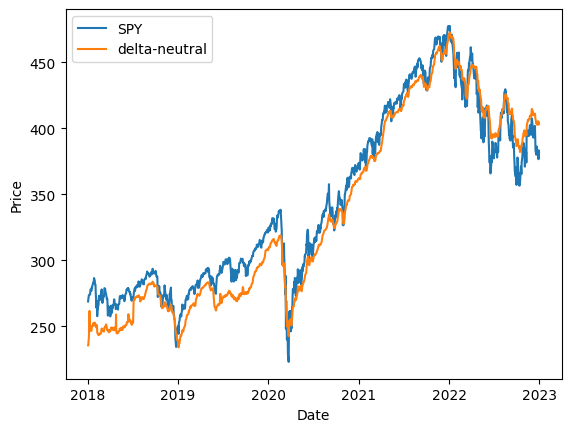

In [7]:
dn_price = flt_option.groupby('date')['delta_neutral_price'].mean().reset_index()
stock_price = df_stock.rename(columns={'ts': 'date'})

# plot spy and delta neutral price
# earliest data: 2010, latest data: 2022
starting_date = '2018-01-01'
ending_date = '2022-12-31'

plt.plot(stock_price[(stock_price['date']>=starting_date)&(stock_price['date']<=ending_date)]['date'], stock_price[(stock_price['date']>=starting_date)&(stock_price['date']<=ending_date)]['close_price'],label='SPY')
plt.plot(dn_price[(dn_price['date']>=starting_date)&(dn_price['date']<=ending_date)]['date'], dn_price[(dn_price['date']>=starting_date)&(dn_price['date']<=ending_date)]['delta_neutral_price'],label='delta-neutral')

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

calculate gamma exposure (GEX), need oi data. we also have gex from squeezemetric

In [8]:
# open interest. we assume to use volume now
flt_option['C_OI'] = flt_option['C_VOLUME'].fillna(0)
flt_option['P_OI'] = flt_option['P_VOLUME'].fillna(0)

In [9]:
# calculate gamma exposure 
contract_size = 100
flt_option['C_gamma_exposure'] = flt_option['C_GAMMA'] * contract_size * flt_option['C_OI'] * flt_option['UNDERLYING_LAST']**2 * 0.01
flt_option['P_gamma_exposure'] = flt_option['P_GAMMA'] * contract_size * flt_option['P_OI'] * flt_option['UNDERLYING_LAST']**2 * 0.01

call_gamma = flt_option.groupby('date')['C_gamma_exposure'].sum()
put_gamma = flt_option.groupby('date')['P_gamma_exposure'].sum()

gamma_exposure = pd.DataFrame({'GEX': call_gamma - put_gamma,'GEX_Skew': (call_gamma - put_gamma)/(call_gamma + put_gamma)}).reset_index()
gamma_exposure.head()

,date,GEX,GEX_Skew
0,2010-01-04,-1.400059e+06,-0.105897
1,2010-01-05,-2.141322e+06,-0.135393
2,2010-01-06,-3.535363e+06,-0.275775
3,2010-01-07,-2.346442e+06,-0.143924
4,2010-01-08,-2.670400e+06,-0.188442


In [10]:
# squeezemetric gex
gex_sq = df_sq.rename(columns={'gex':'gex_sq'})
gex_sq = gex_sq[['date','gex_sq']]

In [11]:
# time series of date with delta-adjusted and gamma exposure

df_1 = pd.merge(stock_price, dn_price, on='date')
df_1['delta_adjusted'] = df_1['close_price'] - df_1['delta_neutral_price']
df_2 = pd.merge(df_1, gex_sq, on='date')

df_3 = pd.merge(df_2, gamma_exposure, on='date')

df_time = df_3[['date', 'delta_adjusted', 'gex_sq','GEX','GEX_Skew', 'close_price']]

some testing, currently the relationship is poor, we dont have oi data for gex skew calculation.

In [12]:
# linear regression of delta_adjusted price and gex_sq

X = df_time['gex_sq']
y = df_time['delta_adjusted']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         delta_adjusted   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     253.2
Date:                Sun, 06 Apr 2025   Prob (F-statistic):           9.99e-55
Time:                        13:43:31   Log-Likelihood:                -10964.
No. Observations:                2906   AIC:                         2.193e+04
Df Residuals:                    2904   BIC:                         2.194e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8052      0.266     40.568      0.0

In [13]:
# compare calculation of gex_sq with GEX (our calculation)
X = df_time['GEX']
y = df_time['gex_sq']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 gex_sq   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     8.464
Date:                Sun, 06 Apr 2025   Prob (F-statistic):            0.00365
Time:                        13:43:31   Log-Likelihood:                -67378.
No. Observations:                2906   AIC:                         1.348e+05
Df Residuals:                    2904   BIC:                         1.348e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.629e+09   5.27e+07     49.874      0.0

visualize gex and spy price. suggest we may focus to find leading indicator to act as trading signal

In [14]:
# use latest SPY data

stock_price = pd.read_csv(os.path.join(data_path, 'SPY_10Y_latest.csv'))
stock_price['date'] = pd.to_datetime(stock_price['date'])

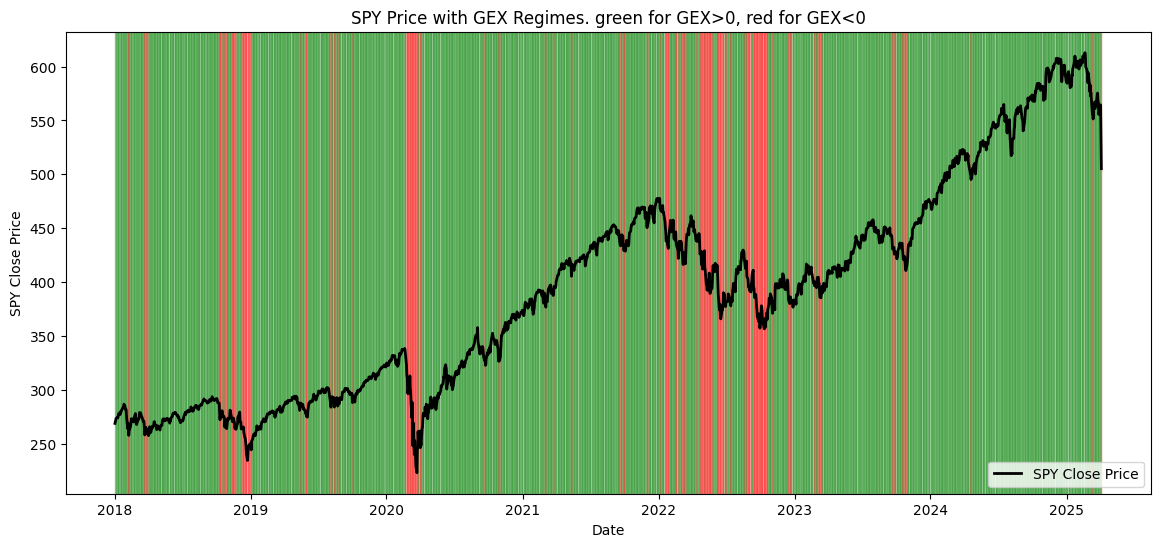

In [15]:
fig, ax = plt.subplots(figsize=(14, 6))

df_time_range = pd.merge(gex_sq,stock_price, on='date')
df_time_range = df_time_range[df_time_range['date']>='2018-01-01']

ax.plot(df_time_range['date'], df_time_range['close_price'], label='SPY Close Price', color='black', linewidth=2)

# Color background: green for GEX > 0, red for GEX < 0
for i in range(1, len(df_time_range)):
    color = 'green' if df_time_range['gex_sq'].iloc[i] > 0 else 'red'
    ax.axvspan(df_time_range['date'].iloc[i-1], df_time_range['date'].iloc[i], color=color, alpha=0.2)

ax.set_title('SPY Price with GEX Regimes. green for GEX>0, red for GEX<0')
ax.set_xlabel('Date')
ax.set_ylabel('SPY Close Price')
ax.legend()
plt.show()


#### we may also study the movement of gex, such as the effects of clustering and mean reverting to understand market regimes

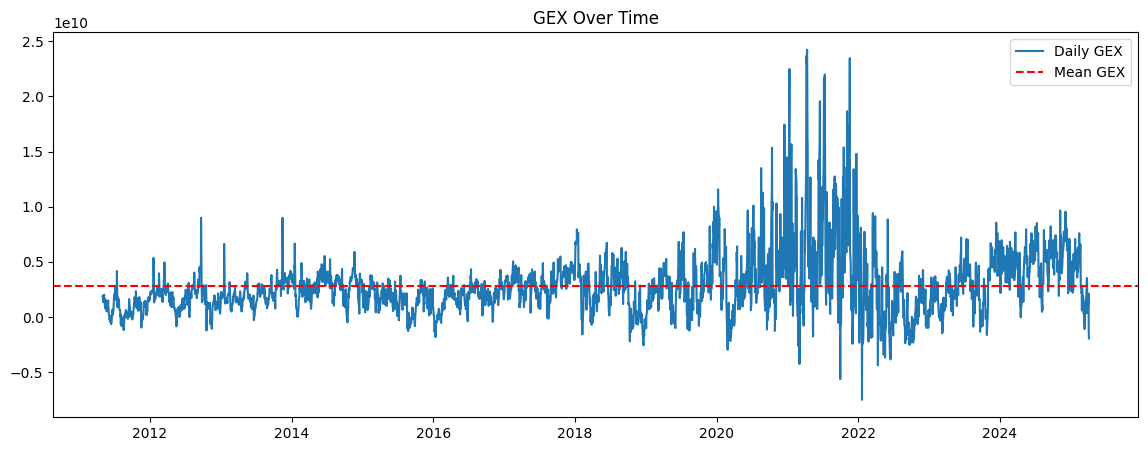

In [16]:
# gex for past 10 year

gex_df = gex_sq[['date','gex_sq']]
gex_df['date'] = pd.to_datetime(gex_df['date'])
gex_df = gex_df.sort_values('date')
gex_df.set_index('date', inplace=True)
plt.figure(figsize=(14, 5))
plt.plot(gex_df['gex_sq'], label='Daily GEX')
plt.axhline(gex_df['gex_sq'].mean(), color='red', linestyle='--', label='Mean GEX')
plt.title('GEX Over Time')
plt.legend()
plt.show()


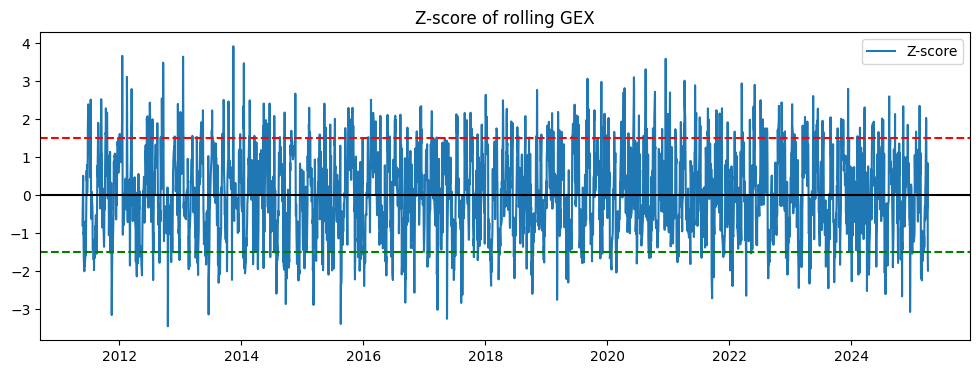

In [17]:
window = 20  # you can try 10, 20, 30, etc.
gex_df['zscore'] = (gex_df['gex_sq'] - gex_df['gex_sq'].rolling(window).mean()) / gex_df['gex_sq'].rolling(window).std()

plt.figure(figsize=(12, 4))
plt.plot(gex_df['zscore'], label='Z-score')
plt.axhline(1.5, color='red', linestyle='--')
plt.axhline(-1.5, color='green', linestyle='--')
plt.axhline(0, color='black', linestyle='-')
plt.legend()
plt.title('Z-score of rolling GEX')
plt.show()

## We understand that GEX is a leading indicator of next day volatility.

caveat: Volatility has clustering effect. So if same-day GEX and volatility are correlated, that may explain next-day correlation too — not necessarily GEX’s predictive power

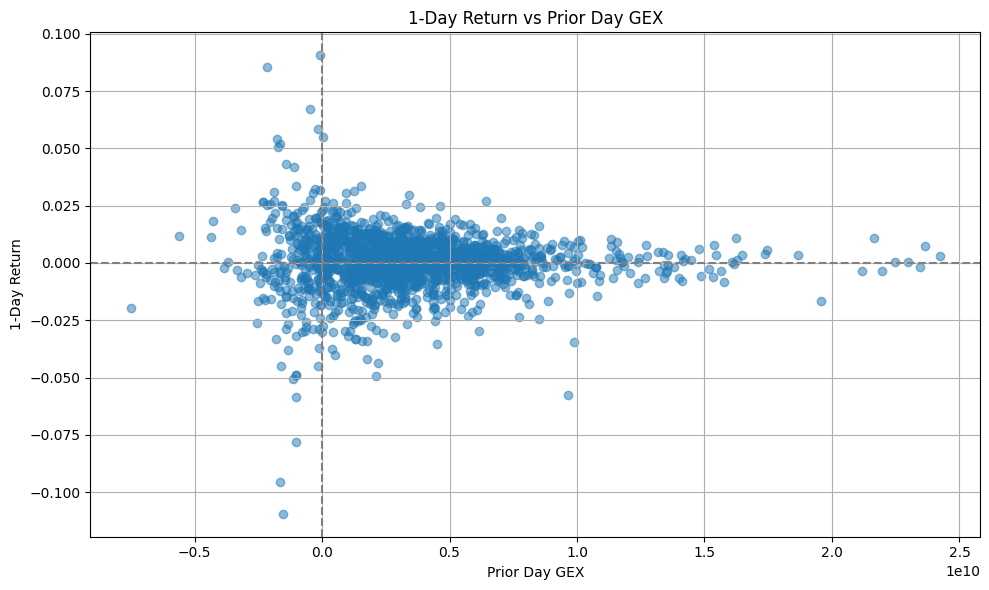

In [28]:
df_time_range = df_time_range[df_time_range['date']>='2016-01-01']
df_time_range.dropna(inplace=True)

df_time_range['1_day_return'] = df_time_range['close_price'] / df_time_range['close_price'].shift(1) - 1

df_time_range['gex_prior'] = df_time_range['gex_sq'].shift(1)


df_time_range.dropna(inplace=True)

plt.figure(figsize=(10, 6))
plt.scatter(df_time_range['gex_prior'], df_time_range['1_day_return'], alpha=0.5)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title('1-Day Return vs Prior Day GEX')
plt.xlabel('Prior Day GEX')
plt.ylabel('1-Day Return')
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
df_vix = pd.read_csv(os.path.join(data_path, 'VIX_History.csv'))
df_vix['date'] = pd.to_datetime(df_vix['DATE'])
df_vix['vix'] = df_vix['CLOSE']/100
df_vix = df_vix[['date','vix']]
df_vix.tail()

,date,vix
3855,2025-03-31,0.2228
3856,2025-04-01,0.2177
3857,2025-04-02,0.2151
3858,2025-04-03,0.3002
3859,2025-04-04,0.4531


In [20]:
stock_price['return'] = stock_price['close_price']/stock_price['close_price'].shift(1) - 1
# Realized volatility over 10 days 
stock_price['rv'] = stock_price['return'].rolling(window=10).std() * np.sqrt(252)

df_vol = pd.merge(df_vix, stock_price, on='date', how='inner')
vol_gex = pd.merge(df_vol,gex_sq, on='date', how='inner')
vol_gex = vol_gex[['date','vix','rv','gex_sq','return','close_price']]

# **Strategy Exploration**

### What we already know (for sure)?

We know that, low GEX on the previous day, predicts a huge volatility the next day, and the reverse is also true.

No implication for price direction.

Thus, we may be hopeful to build a volatility-based strategy. Long straddle if we think volatility will shoot up, short straddle if we think volatility will go down.

However, for this strategy to be useful, we also need to know whether the current volatility is cheap or expensive.

### To think: How do we achieve this?

The below are some suggestions from AI:

Use VIX (implied volatility, IV) and realized volatility, RV to measure the pricing of volatilities. 

If IV < RV, the options are cheap and when GEX is low, we LONG straddle the next day (anticipate high volatility).

If IV > RV, the options are expensive and when GEX is high, we SHORT straddle the next day (anticipate low volatility).

For other cases, no action is taken.

To make simplest evaluation:

We assume at closing, when the signal appears, we made the trade. We hold it till the end of the next day. Put fix amount of capital for every trade

take PnL percentage ~ Absolute Daily Return - Daily_IV (approximation for straddle profit???) *culmulative below just means add up all these pct (not compounded)

Obviously, this is just exploration, far far from perfect.

### Lots of works can be done/decided/improved:

How and what threshold to define cheap/expensive volatility, also how to define low/high GEX

Which straddle exactly we choose to trade? Use actual trade to evaluate performance.

Should study the mean reversion or momentum behaviour under different regime to enhance strategy choice.

Put larger capital in more extreme environment, according to confidence level.

What is the suitable holding period? For high volatility we may wish to hold longer especially in a downwards environment.

Enter frequency. Stop Loss. Take profit. Sharpe Ratio related optimization.




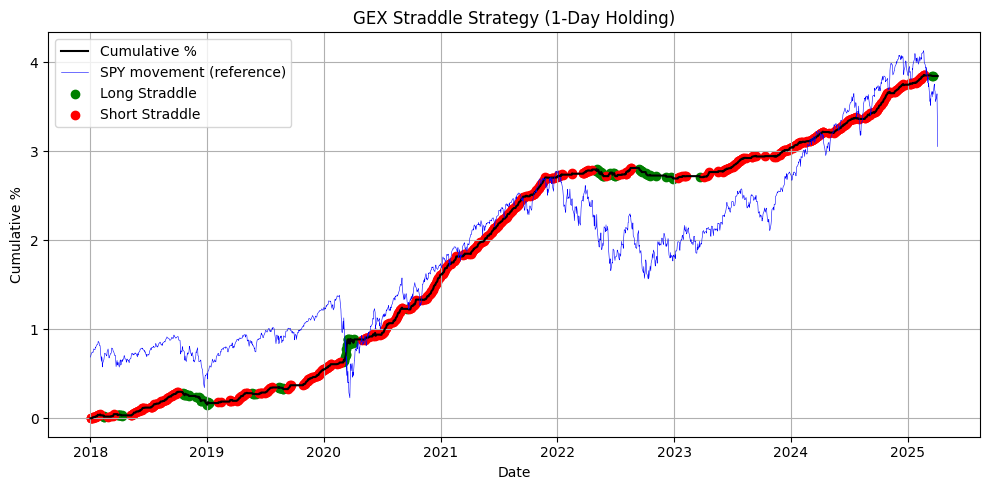

Days with no trade:  916 

Days with long straddle:  120
Days with long straddle and positive PnL:  28
Days with long straddle and negative PnL:  52 

Days with short straddle:  789
Days with short straddle and positive PnL:  587
Days with short straddle and negative PnL:  66 

Days with positive PnL:  723
Days with negative PnL:  186


In [44]:
df = vol_gex.copy()
df = df[df['date']>='2018-01-01']
# Calculate implied daily volatility from VIX (VIX is annualized)
df['IV_daily'] = df['vix'] / np.sqrt(252)

# Volatility Risk Premium (VRP = IV - RV)
df['VRP'] = df['vix'] - df['rv']  

# Calculate low & high GEX thresholds
gex_low = df['gex_sq'].quantile(0.2)
gex_high = df['gex_sq'].quantile(0.5)

# Generate trade signal
def generate_signal(row):
    if row['gex_sq'] < gex_low and row['VRP'] < 0:
        return 1  # Buy straddle
    elif row['gex_sq'] > gex_high and row['VRP'] > 0:
        return -1  # Sell straddle
    else:
        return 0  # No trade

df['signal'] = df.apply(generate_signal, axis=1)

# Calculate profitability
df['straddle_pnl'] = np.where(
    df['signal'].shift(1) == 1,
    np.abs(df['return']) - df['IV_daily'],  # Long straddle
    np.where(
        df['signal'].shift(1) == -1,
        df['IV_daily'] - np.abs(df['return']),  # Short straddle
        0
    )
)

df['cumulative_percentage'] = df['straddle_pnl'].cumsum()

plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['cumulative_percentage'], label='Cumulative %', color='black')

plt.plot(df['date'], (df['close_price']/100)-2, label='SPY movement (reference)', color='blue',lw=0.4)

# Plot long straddle trades (signal = 1)
long_days = df[df['signal'].shift(1) == 1]
plt.scatter(long_days['date'], long_days['cumulative_percentage'], color='green', label='Long Straddle', alpha=1)

# Plot short straddle trades (signal = -1)
short_days = df[df['signal'].shift(1) == -1]
plt.scatter(short_days['date'], short_days['cumulative_percentage'], color='red', label='Short Straddle', alpha=1)

# Format the plot
plt.title("GEX Straddle Strategy (1-Day Holding)")
plt.xlabel("Date")
plt.ylabel("Cumulative %")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Days with no trade: ", (df['signal']== 0).sum(),'\n')
print("Days with long straddle: ", (df['signal']== 1).sum())
print("Days with long straddle and positive PnL: ", ((df['signal']== 1)&(df['straddle_pnl'] > 0)).sum())
print("Days with long straddle and negative PnL: ", ((df['signal']== 1)&(df['straddle_pnl'] < 0)).sum(),'\n')

print("Days with short straddle: ", (df['signal']== -1).sum())
print("Days with short straddle and positive PnL: ", ((df['signal']== - 1)&(df['straddle_pnl'] > 0)).sum())
print("Days with short straddle and negative PnL: ", ((df['signal']== - 1)&(df['straddle_pnl'] < 0)).sum(),'\n')

print("Days with positive PnL: ", (df['straddle_pnl'] > 0).sum())
print("Days with negative PnL: ", (df['straddle_pnl'] < 0).sum())

### Currently discontinued: 


Just an altenative method to calculate delta-neutral price based on exposure and obviously OI is needed. Not sure about the methodology


from scipy.stats import norm
from scipy.optimize import brentq

def net_market_delta(S, group, r):
    K = group['STRIKE'].values
    T = group['DTE'].values / 365
    c_sigma = group['C_IV'].values
    p_sigma = group['P_IV'].values
    c_oi = group['C_OI'].values
    p_oi = group['P_OI'].values

    # Compute d1 for calls and puts
    d1_call = (np.log(S / K) + (r + 0.5 * c_sigma**2) * T) / (c_sigma * np.sqrt(T))
    d1_put  = (np.log(S / K) + (r + 0.5 * p_sigma**2) * T) / (p_sigma * np.sqrt(T))

    # Compute deltas
    delta_c = norm.cdf(d1_call)
    delta_p = norm.cdf(d1_put) - 1

    # Net delta
    total = np.sum(c_oi * delta_c + p_oi * delta_p)
    return total

def solve_delta_neutral(group, r=0.01):
    # Filter out bad rows
    group = group[
        (group['C_IV'] > 0) &
        (group['P_IV'] > 0) &
        (group['DTE'] > 0) &
        (group['STRIKE'] > 0)
    ].copy()

    if group.empty:
        return np.nan

    mid_price = group['UNDERLYING_LAST'].iloc[0]
    low, high = mid_price * 0.5, mid_price * 1.5

    try:
        delta_low = net_market_delta(low, group, r)
        delta_high = net_market_delta(high, group, r)
        #print(group['date'].iloc[0], f"Net Delta @ Low={delta_low}, High={delta_high}")
        return brentq(lambda S: net_market_delta(S, group, r), low, high)
    except ValueError:
        return np.nan

    

f = flt_option.groupby('date').apply(solve_delta_neutral).reset_index()
f.columns = ['date', 'delta_neutral']


dn_price = f
stock_price = df_stock.rename(columns={'ts': 'date'})

starting_date = '2018-01-01'
ending_date = '2022-12-31'

plt.plot(stock_price[(stock_price['date']>=starting_date)&(stock_price['date']<=ending_date)]['date'], stock_price[(stock_price['date']>=starting_date)&(stock_price['date']<=ending_date)]['close_price'],label='SPY')
plt.plot(dn_price[(dn_price['date']>=starting_date)&(dn_price['date']<=ending_date)]['date'], dn_price[(dn_price['date']>=starting_date)&(dn_price['date']<=ending_date)]['delta_neutral'],label='delta-neutral')

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


